CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Jupyter-specific
%matplotlib inline

In [43]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL = 'cnn' 
DS_INFO = 'complete'
NUM_EPOCHS = 50
BATCH_SIZE = 64

IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

Some parameters

In [3]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('*/*/*.*g')))
STEPS_PER_EPOCH = np.ceil(DATASET_SIZE/BATCH_SIZE)

directories = np.array([item.name for item in data_dir.glob('train/*') if item.name != 'metadata.json'])

class_names = directories
NUM_CLASSES = len(directories)
print ("Class names: ", class_names)

Class names:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']


In [4]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [5]:
samples_per_class = []
for class_name in class_names:
    class_samples = len(list(data_dir.glob('*/'+class_name+'/*.*g')))
    samples_per_class.append(class_samples)
    print('{0:18}: {1:3d}'.format(class_name, class_samples))

print ('\nTotal number of images: {}, in {} classes'.format(DATASET_SIZE, NUM_CLASSES))

# If one class contains more than half of the entire sample size
if np.max(samples_per_class) > DATASET_SIZE//2:
    print ("But the dataset is mainly shit")

cat               : 6000
airplane          : 6000
deer              : 6000
automobile        : 6000
ship              : 6000
horse             : 6000
truck             : 6000
dog               : 6000
bird              : 6000
frog              : 6000

Total number of images: 60000, in 10 classes


### Loading images with `tf.data.Dataset`.

In [6]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*/*.png'))

A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get class integer from class-list
    label_int = tf.reduce_min(tf.where(tf.equal(parts[-2], class_names)))
    # cast to tensor array with dtype=uint8
    return tf.dtypes.cast(label_int, tf.int32)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Showing an example image/label pair

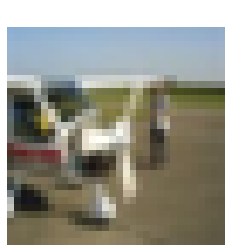

In [8]:
def show_image(img):
    if (isinstance(img, tf.data.Dataset)):
        for image, label in img:
            plt.figure(frameon=False, facecolor='white')
            title = class_names[label.numpy()]#+" ["+str(label.numpy())+"]"
            plt.title(title, fontdict={'color':'white','size':20})
            plt.imshow(image.numpy())
            plt.axis('off')
    else:
        plt.figure(frameon=False, facecolor='white')
        plt.title("None", fontdict={'color':'white','size':20})
        plt.imshow(img.numpy())
        plt.axis('off')

# Take one image
show_image(labeled_ds.take(1))

### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

Split into training, test and validation dataset

In [9]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

train_ds = labeled_ds.take(train_size)
test_ds = labeled_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [10]:
def get_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

print ("{:32} {:>5}".format("Full dataset sample size:", get_size(labeled_ds)))
print ("{:32} {:>5}".format("Train dataset sample size:", get_size(train_ds)))
print ("{:32} {:>5}".format("Test dataset sample size:", get_size(test_ds)))
print ("{:32} {:>5}".format("Validation dataset sample size:", get_size(val_ds)))

Full dataset sample size:        60000
Train dataset sample size:       42000
Test dataset sample size:         9000
Validation dataset sample size:   9000


In [11]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=3000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create training, test and validation dataset
train_ds = prepare_for_training(train_ds, cache="./cache/{}_train.tfcache".format(IMG_WIDTH))
test_ds = prepare_for_training(test_ds, cache="./cache/{}_test.tfcache".format(IMG_WIDTH))
val_ds = prepare_for_training(val_ds, cache="./cache/{}_val.tfcache".format(IMG_WIDTH))

## Training
### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [12]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [42]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [14]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          3

Compile and train the model

In [45]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(MODEL), update_freq='batch')]

In [46]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 656 steps, validate for 140 steps
Epoch 1/50
656/656 [==============================] - 4s 6ms/step - loss: 1.4860 - accuracy: 0.4723 - val_loss: 1.5344 - val_accuracy: 0.4531
Epoch 2/50
656/656 [==============================] - 4s 5ms/step - loss: 1.1500 - accuracy: 0.5940 - val_loss: 1.0711 - val_accuracy: 0.6202
Epoch 3/50
656/656 [==============================] - 3s 5ms/step - loss: 1.0027 - accuracy: 0.6482 - val_loss: 1.1623 - val_accuracy: 0.5929
Epoch 4/50
656/656 [==============================] - 3s 5ms/step - loss: 0.9030 - accuracy: 0.6829 - val_loss: 0.8920 - val_accuracy: 0.6818
Epoch 5/50
656/656 [==============================] - 3s 5ms/step - loss: 0.8237 - accuracy: 0.7091 - val_loss: 0.8275 - val_accuracy: 0.7042
Epoch 6/50
656/656 [==============================] - 3s 5ms/step - loss: 0.7532 - accuracy: 0.7368 - val_loss: 0.7863 - val_accuracy: 0.7270
Epoch 7/50
656/656 [==============================] - 4s 5ms/step - loss: 0.7024 - accuracy: 0.7520 - va

In [17]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [47]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

140/140 - 0s - loss: 0.5690 - accuracy: 0.9041


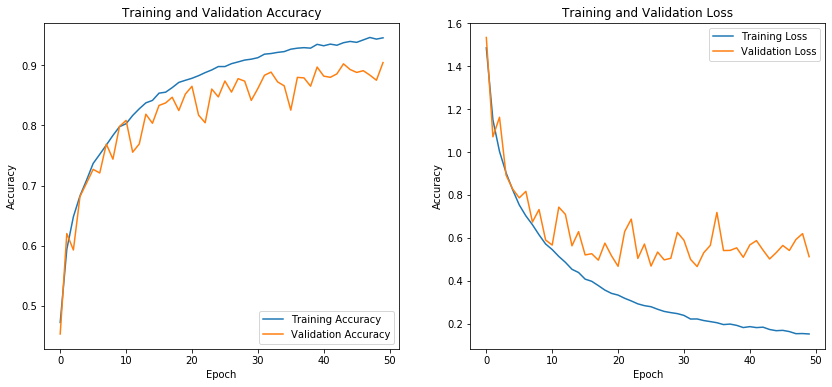

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [49]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0000 cat
0.0000 airplane
0.1025 deer
0.0000 automobile
0.0000 ship
0.0000 horse
0.0000 truck
0.0000 dog
0.0153 bird
0.8822 frog

Label: frog
Predicton: frog


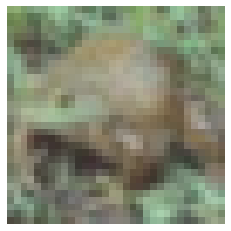

In [65]:
# Get a random image and label
rand = np.random.randint(0, BATCH_SIZE)
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,class_names[i]))

print ("\nLabel:", class_names[label])
print ("Predicton:", class_names[np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [66]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = class_names[labels[i]]
    prediction = class_names[np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  bird        bird      
  1  horse       horse     
  2  bird        bird      
  3  truck       truck     
  4  bird        bird      
  5  truck       truck     
  6  bird        bird      
  7  dog         dog       
  8  deer        deer      
  9  airplane    airplane  
 10  automobile  automobile
 11  dog         dog       
 12  cat         cat       
 13  frog        cat         Wrong
 14  ship        ship      
 15  bird        bird      
 16  frog        cat         Wrong
 17  cat         cat       
 18  deer        deer      
 19  truck       truck     
 20  automobile  automobile
 21  frog        frog      
 22  horse       horse     
 23  dog         dog       
 24  airplane    airplane  
 25  cat         cat       
 26  airplane    airplane  
 27  frog        frog      
 28  frog        frog      
 29  dog         dog       
 30  truck       truck     
 31  deer        deer      
 32  ship        ship      
 33  airplane